In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import defaultdict

# 短语情感分类

对Phrase字段中的文本进行分类，分类结果为

- 0 - negative
- 1 - somewhat negative
- 2 - neutral
- 3 - somewhat positive
- 4 - positive

In [2]:
train = pd.read_csv('train.tsv', sep='\t')
train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [3]:
train.sample(20)

,PhraseId,SentenceId,Phrase,Sentiment
18643,18644,818,"`` I guess I come from a broken family , and m...",2
98114,98115,5140,that tends to hammer home every one of its points,2
38118,38119,1813,Spirit 's visual imagination reminds you of wh...,4
27816,27817,1277,would not likely,2
40161,40162,1923,of its provocative conclusion,3
3061,3062,114,rouses us .,3
83741,83742,4329,such exuberance and passion,4
149636,149637,8145,plenty of funny movies,3
133567,133568,7206,A photographic marvel,3
89882,89883,4677,likely to enjoy on a computer,2


## 数据预处理
1. 统计单词频率并保留频率最高的1000个单词，构建单词到索引的映射，以及构建索引到单词的映射。

In [4]:
# 使用部分数据
# train = train.head(1000)

# 创建字典
len_list = []
word_freq_map = defaultdict(int)
for sentence in train.Phrase:
    words = sentence.split()
    words = [w.lower() for w in words] # 统一为小写
    len_list.append(len(words))
    for word in words:
        word_freq_map[word] += 1

word_freq_map = dict(sorted(word_freq_map.items(),
                                   key=lambda x: x[1], reverse=True))
top_k_words = 2000
# 使用列表根据序号查找单词 (特殊词 <UNK> 表示未登录词)
idx2word = list(word_freq_map.keys())[:top_k_words] + ['<UNK>'] # 
# 使用词典根据单词查找序号
word2idx = {idx2word[i]:i for i in range(len(idx2word))}
print('<UNK>:', word2idx['<UNK>'])

<UNK>: 2000


2. 构建基于Bag-of-Words的数据集

In [5]:
# Bag of Words dataset 
def extract_BoW_feat(df, idx2word, word2idx):
    X = []
    for sentence in df.Phrase:
        x = np.zeros(len(idx2word)) # BoW不需要不考虑<PAD>
        words = sentence.split()
        words = [w.lower() for w in words]
        for w in words:
            if w in word2idx:
                x[word2idx[w]]+=1
            else:
                x[word2idx['<UNK>']]+=1
        X.append(x)
    X = np.array(X)
    y = np.array(df.Sentiment)
    return X, y

In [6]:
X,y = extract_BoW_feat(train, idx2word, word2idx)

In [7]:
train_num = int(len(X) * 0.8)
X_train = X[:train_num]
y_train = y[:train_num]
X_val = X[train_num:]
y_val = y[train_num:]

In [8]:
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
# 创建训练与验证数据集
train_dataset = SentimentDataset(X_train, y_train)
val_dataset = SentimentDataset(X_val, y_val)

## 构建模型

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hid_dim, output_dim)  # 5 classes for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=-1)
        return x



In [11]:
# Create an instance of the MLP model
model = MLP(top_k_words+1, 100, 5)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

## 模型训练

In [19]:
import matplotlib.pyplot as plt
import numpy as np

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_acc = (train_correct/len(train_loader.dataset)) * 100
    train_accuracies.append(train_acc)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc = (correct / len(val_loader.dataset)) * 100
    val_accuracies.append(val_acc)

    # Print training and validation loss, and validation accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")




Epoch 1/10, Loss: 0.0364, Val Loss: 0.0416, Train Acc: 74.22%, Val Acc: 57.10%
Epoch 2/10, Loss: 0.0363, Val Loss: 0.0416, Train Acc: 74.33%, Val Acc: 57.10%
Epoch 3/10, Loss: 0.0363, Val Loss: 0.0415, Train Acc: 74.48%, Val Acc: 57.30%
Epoch 4/10, Loss: 0.0363, Val Loss: 0.0416, Train Acc: 74.54%, Val Acc: 57.01%
Epoch 5/10, Loss: 0.0362, Val Loss: 0.0416, Train Acc: 74.70%, Val Acc: 57.09%
Epoch 6/10, Loss: 0.0362, Val Loss: 0.0416, Train Acc: 74.76%, Val Acc: 57.05%
Epoch 7/10, Loss: 0.0362, Val Loss: 0.0416, Train Acc: 74.86%, Val Acc: 56.95%
Epoch 8/10, Loss: 0.0361, Val Loss: 0.0416, Train Acc: 74.95%, Val Acc: 57.03%
Epoch 9/10, Loss: 0.0361, Val Loss: 0.0416, Train Acc: 75.06%, Val Acc: 57.01%
Epoch 10/10, Loss: 0.0361, Val Loss: 0.0416, Train Acc: 75.10%, Val Acc: 56.93%


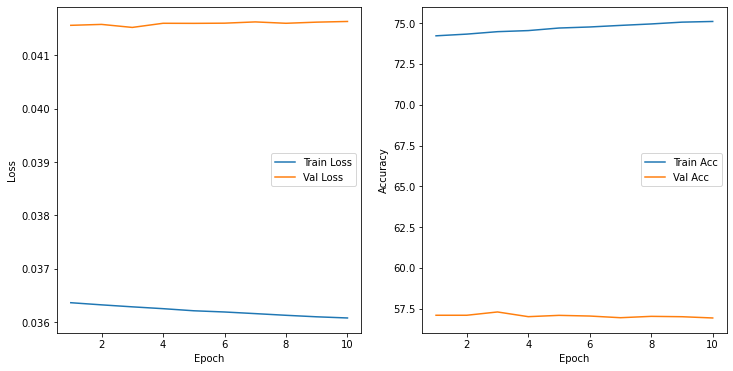

In [20]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(np.arange(1, num_epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.arange(1, num_epochs+1), train_accuracies, label='Train Acc')
plt.plot(np.arange(1, num_epochs+1), val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 生成测试结果

In [22]:
test = pd.read_csv('test.tsv', sep='\t')
test.sample(5)

,PhraseId,SentenceId,Phrase
18414,174475,9358,promising material
40358,196419,10448,"is , regrettably ,"
22440,178501,9550,the string of insultingly innocuous
52356,208417,11087,wraps back around on itself in the kind of ele...
51498,207559,11038,white-trash


In [23]:
test['Sentiment'] = 0 # add fake label
X_test,y_test = extract_BoW_feat(test, idx2word, word2idx)

In [24]:
test_dataset = SentimentDataset(X_test, y_test)
batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
all_predicted = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predicted.append(predicted.numpy())
y_test = np.concatenate(all_predicted)

In [25]:
test['Sentiment']=y_test
selected_columns = ['PhraseId', 'Sentiment']
test[selected_columns].to_csv('Sentiment_BoW_MLP.csv', index=False)